In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
from math import sqrt, floor
from heapq import heappop, heappush
from datetime import datetime
import seaborn as sns
import pandas as pd

from theta.src.grid import Map

%matplotlib inline

In [2]:
folders = ["analysis/results/starcraft/",
          "analysis/results/paris/",
          "analysis/results/maze/",
          "analysis/results/random/",
          "analysis/results/room/"]
files = ["NovaStation",
        "Paris_1_256",
        "maze512-32-7",
        "random512-10-5",
        "16room_005"]
setName = ["SC",
          "City",
          "Maze",
          "Rand",
          "Room"]

In [3]:
names_anya = [".anya"]
labels_anya = ["Anya"]

In [4]:
names_theta = [".theta.euclidian", ".theta.weighted", ".theta_ap.euclidian", ".theta_ap.weighted", ".lazy_theta.euclidian", ".lazy_theta.weighted"]
labels_theta = ["Basic Theta", "Basic Theta (wh)", "AP Theta", "AP Theta (wh)", "Lazy Theta", "Lazy Theta (wh)"]

In [5]:
names_2kastar = [".astar_2k.euclidian.w=1_k=3", ".astar_2k.euclidian.w=1_k=4", ".astar_2k.euclidian.w=1_k=5",
                 ".canonical.euclidian.w=1_k=3", ".canonical.euclidian.w=1_k=4", ".canonical.euclidian.w=1_k=5",
                 ".canonical.euclidian.w=1_k=6", ".canonical.euclidian.w=1_k=7",
                 ".astar_2k.h_2k.w=1_k=3", ".astar_2k.h_2k.w=1_k=4", ".astar_2k.h_2k.w=1_k=5",
                 ".canonical.h_2k.w=1_k=3", ".canonical.h_2k.w=1_k=4", ".canonical.h_2k.w=1_k=5"]
labels_2kastar = ["A* 8", "A* 16", "A* 32", 
                  "C A* 8", "C A* 16", "C A* 32",
                  "C A* 64", "C A* 128",
                  "A* 8 h_2k", "A* 16 h_2k", "A* 32 h_2k", 
                  "C A* 8 h_2k", "C A* 16 h_2k", "C A* 32 h_2k"]

In [6]:
def load_data(names, labels, folder):
    data_out = []
    for f in range(len(files)):
        table_list = []
        for i in range(len(names)):
            table = pd.read_csv(folders[f] + folder + files[f] + names[i] + ".stat")
            table.insert(0, "name", labels[i])
            table.insert(0, "map", setName[f])
            table_list.append(table)

        data_out.append(table_list)
    return data_out

In [7]:
def load_data_hk(names, labels, hs, ks, folder):
    data_out = []
    for f in range(len(files)):
        table_list = []
        for i in range(len(names)):
            table = pd.read_csv(folders[f] + folder + files[f] + names[i] + ".stat")
            table.insert(0, "name", labels[i])
            table.insert(0, "heuristic", hs[i])
            table.insert(0, "k", ks[i])
            table.insert(0, "map", setName[f])
            table_list.append(table)

        data_out.append(table_list)
    return data_out

In [8]:
multy_data_2kastar = load_data(names_2kastar, labels_2kastar, "astar_2k/")

In [9]:
multy_data_theta = load_data(names_theta, labels_theta, "theta/")

In [10]:
multy_data_anya = load_data(names_anya, labels_anya, "anya/")

In [11]:
def count_suboptimal(ideal_multy_data, index, multy_data):
    for i in range(len(multy_data)):
        for j in range(len(multy_data[i])):
            multy_data[i][j]["suboptimal"] = multy_data[i][j]["way_length"] / ideal_multy_data[i][index]["way_length"]
            multy_data[i][j]["extra_suboptimal, %"] = 100 * multy_data[i][j]["suboptimal"] - 100

In [12]:
def norm_stats(ideal_multy_data, index, multy_data):
    for i in range(len(multy_data)):
        for j in range(len(multy_data[i])):
            multy_data[i][j]["normed_expansions"] \
            = multy_data[i][j]["expansions"] / ideal_multy_data[i][index]["expansions"]
            multy_data[i][j]["normed_tree_size"] \
            = multy_data[i][j]["max_tree_size"] / ideal_multy_data[i][index]["max_tree_size"]

In [13]:
def norm_custom_stat(ideal_multy_data, index, multy_data, stat_name):
    for i in range(len(multy_data)):
        for j in range(len(multy_data[i])):
            multy_data[i][j]["normed_" + stat_name] \
            = multy_data[i][j][stat_name] / ideal_multy_data[i][index][stat_name]

In [14]:
def select_multy_data(multy_data, indices):
    data_out = []
    for i in range(len(multy_data)):
        data_i = []
        for j in indices:
            data_i.append(multy_data[i][j])
        data_out.append(data_i)
    return data_out

In [15]:
def unite_multy_data(multy_data):
    data_out = []
    for i in range(len(multy_data)):
        main_table = pd.DataFrame()
        for j in range(len(multy_data[i])):
            main_table = pd.concat([main_table, multy_data[i][j]], ignore_index = True)
        data_out.append(main_table)
    return data_out

In [16]:
def unite_multy_data_i(multy_data, indices):
    data_out = []
    for i in range(len(multy_data)):
        main_table = pd.DataFrame()
        for j in indices:
            main_table = pd.concat([main_table, multy_data[i][j]], ignore_index = True)
        data_out.append(main_table)
    return data_out

In [17]:
def unite_maps(data):
    main_table = pd.DataFrame()
    for i in range(len(data)):
        main_table = pd.concat([main_table, data[i]], ignore_index = True)
    return main_table

In [18]:
count_suboptimal(multy_data_anya, 0, multy_data_anya)

In [19]:
count_suboptimal(multy_data_anya, 0, multy_data_theta)

In [20]:
count_suboptimal(multy_data_anya, 0, multy_data_2kastar)

In [21]:
norm_stats(multy_data_2kastar, 0, multy_data_2kastar)

In [22]:
norm_stats(multy_data_2kastar, 0, multy_data_theta)

In [23]:
norm_stats(multy_data_2kastar, 0, multy_data_anya)

In [24]:
data_2kastar = unite_multy_data(multy_data_2kastar)

In [25]:
data_theta = unite_multy_data(multy_data_theta)
multy_data_theta_vs_lazy = select_multy_data(multy_data_theta, [0, 4])
norm_custom_stat(multy_data_theta_vs_lazy, 0, multy_data_theta_vs_lazy, "runtime")
data_theta_vs_lazy = unite_multy_data(multy_data_theta_vs_lazy)
general_theta_vs_lazy = unite_maps(data_theta_vs_lazy)

In [26]:
multy_data_wh = select_multy_data(multy_data_theta, [4, 5])
norm_custom_stat(multy_data_wh, 0, multy_data_wh, "runtime")
data_wh = unite_multy_data(multy_data_wh)
general_wh = unite_maps(data_wh)

In [27]:
multy_data_ap_vs_lazy_classic = select_multy_data(multy_data_theta, [2, 4])
norm_custom_stat(multy_data_ap_vs_lazy_classic, 0, multy_data_ap_vs_lazy_classic, "runtime")
data_ap_vs_lazy_classic = unite_multy_data(multy_data_ap_vs_lazy_classic)
general_ap_vs_lazy_classic = unite_maps(data_ap_vs_lazy_classic)

In [28]:
data_anya = unite_multy_data(multy_data_anya)

In [29]:
data_final_theta = unite_multy_data_i(multy_data_theta, [2, 4])

In [30]:
data_final_2kastar = unite_multy_data_i(multy_data_2kastar, [7])
data_final2_2kastar = unite_multy_data_i(multy_data_2kastar, [3, 4, 5, 6, 7])

In [31]:
data_theta[0]

,map,name,difficulty,expansions,runtime,way_length,suboptimal,max_tree_size,"extra_suboptimal, %",normed_expansions,normed_tree_size
0,SC,Basic Theta,0,2,0.000262,2.236068,1.000000,14,0.000000,1.000000,1.166667
1,SC,Basic Theta,2,9,0.000969,9.486833,1.000000,42,0.000000,0.360000,0.352941
2,SC,Basic Theta,5,23,0.003191,19.924859,1.000000,90,0.000000,0.244681,0.273556
3,SC,Basic Theta,8,38,0.005015,30.695188,1.000497,140,0.049678,0.190955,0.235690
4,SC,Basic Theta,11,140,0.019020,44.124965,1.000000,310,0.000000,0.843373,0.603113
...,...,...,...,...,...,...,...,...,...,...,...
595,SC,Lazy Theta (wh),262,73811,16.797491,985.787889,1.000006,75689,0.000554,1.032509,1.011169
596,SC,Lazy Theta (wh),264,86065,19.138428,989.998229,1.000014,87015,0.001428,1.014260,1.010005
597,SC,Lazy Theta (wh),267,87377,19.701632,1003.890861,1.001054,88182,0.105407,1.004172,1.000363
598,SC,Lazy Theta (wh),270,86864,19.536279,1013.342264,1.000104,87665,0.010425,1.007867,1.004515


In [32]:
def smooth_data(stat_type, in_data, labels, smc = 6):
    
    result_data = []

    for n in range(len(folders)):
        max_diff = max(in_data[n]["difficulty"]) 
        c = max_diff // smc # smooth const
        difficulty = [i + c for i in range(max_diff - 2 * c + 1)]
        main_table = pd.DataFrame()
        for i in range(len(labels)):
            table = pd.DataFrame()
            sum_time = [0] * (max_diff - 2 * c + 1)
            cnt_time = [0] * (max_diff - 2 * c + 1)

            for j in range(len(in_data[n].index)):
                if in_data[n]["name"][j] == labels[i]:
                    diff = in_data[n]["difficulty"][j]
                    runtime = in_data[n][stat_type][j]
                    for k in range(max(0, diff - 2 * c), min(max_diff - 2 * c, diff) + 1):
                        sum_time[k] += runtime
                        cnt_time[k] += 1



            table["difficulty"] = difficulty
            table["sum_time"] = sum_time
            table["cnt"] = cnt_time
            table[stat_type] = table["sum_time"] / table["cnt"]
            table.pop("sum_time")
            table.pop("cnt")
            table.insert(0, "name", str(labels[i]))

            main_table = pd.concat([main_table, table], ignore_index = True)
        result_data.append(main_table)
    return result_data

In [33]:
def smooth_data_hk(stat_type, in_data, labels, hs, ks, smc = 6):
    
    result_data = []

    for n in range(len(folders)):
        max_diff = max(in_data[n]["difficulty"]) 
        c = max_diff // smc # smooth const
        difficulty = [i + c for i in range(max_diff - 2 * c + 1)]
        main_table = pd.DataFrame()
        for i in range(len(labels)):
            table = pd.DataFrame()
            sum_time = [0] * (max_diff - 2 * c + 1)
            cnt_time = [0] * (max_diff - 2 * c + 1)

            for j in range(len(in_data[n].index)):
                if in_data[n]["name"][j] == labels[i]:
                    diff = in_data[n]["difficulty"][j]
                    runtime = in_data[n][stat_type][j]
                    for k in range(max(0, diff - 2 * c), min(max_diff - 2 * c, diff) + 1):
                        sum_time[k] += runtime
                        cnt_time[k] += 1



            table["difficulty"] = difficulty
            table["sum_time"] = sum_time
            table["cnt"] = cnt_time
            table[stat_type] = table["sum_time"] / table["cnt"]
            table["average_" + stat_type] = table[stat_type].mean()
            table.pop("sum_time")
            table.pop("cnt")
            table.insert(0, "name", str(labels[i]))
            table.insert(0, "heuristic", str(hs[i]))
            table.insert(0, "k", str(ks[i]))

            main_table = pd.concat([main_table, table], ignore_index = True)
        result_data.append(main_table)
    return result_data

In [34]:
runtime_data_theta = smooth_data("runtime", data_theta, labels_theta)
runtime_data_theta_vs_lazy = smooth_data("runtime", data_theta_vs_lazy, [labels_theta[0], labels_theta[4]])
runtime_data_2kastar = smooth_data("runtime", data_2kastar, labels_2kastar)
runtime_data_anya = smooth_data("runtime", data_anya, labels_anya)

# Theta

In [35]:
runtime_data_theta_vs_lazy[0]

,name,difficulty,runtime
0,Basic Theta,45,1.173995
1,Basic Theta,46,1.258934
2,Basic Theta,47,1.258934
3,Basic Theta,48,1.355762
4,Basic Theta,49,1.355762
...,...,...,...
363,Lazy Theta,224,10.779525
364,Lazy Theta,225,11.194328
365,Lazy Theta,226,11.194328
366,Lazy Theta,227,11.194328


# Basic vs Lazy

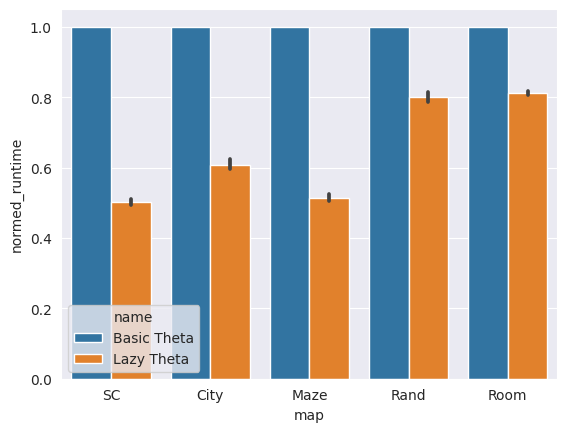

In [36]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=general_theta_vs_lazy, x="map", y="normed_runtime", hue="name")

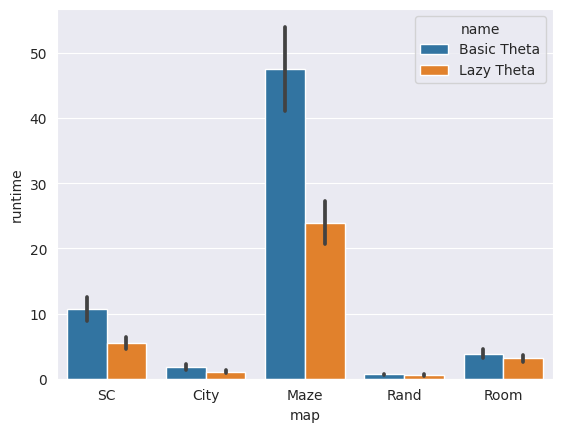

In [37]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=general_theta_vs_lazy, x="map", y="runtime", hue="name")

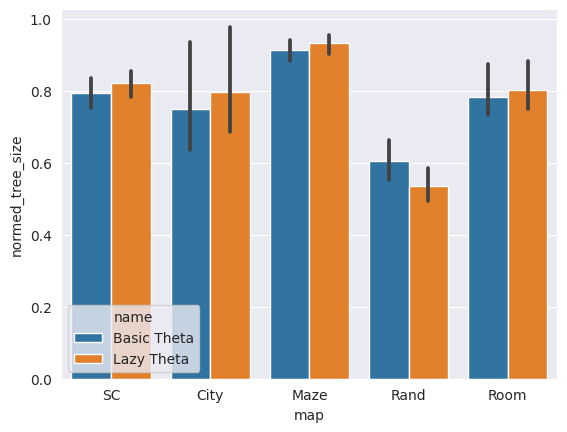

In [38]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=general_theta_vs_lazy, x="map", y="normed_tree_size", hue="name")

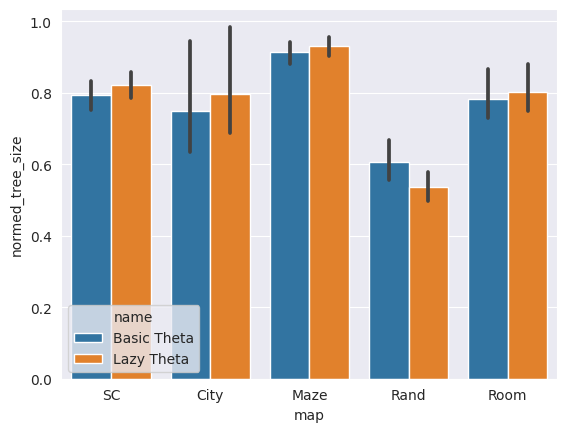

In [39]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=general_theta_vs_lazy, x="map", y="normed_tree_size", hue="name")

# Theta AP vs Lazy

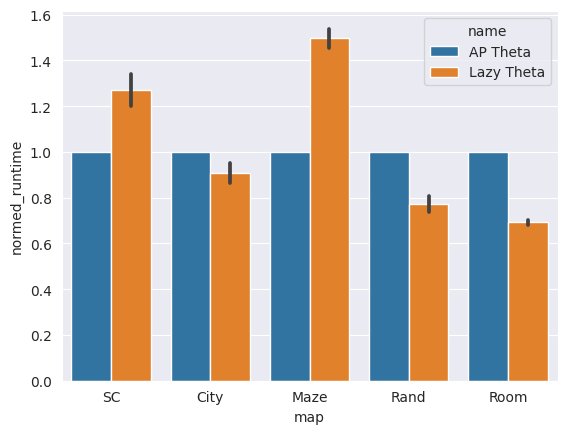

In [40]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=general_ap_vs_lazy_classic, x="map", y="normed_runtime", hue="name")

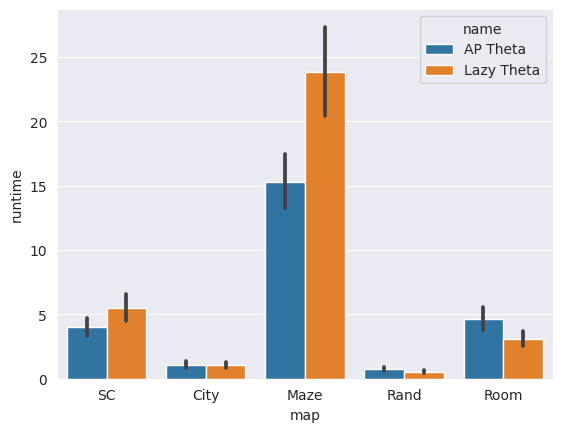

In [41]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=general_ap_vs_lazy_classic, x="map", y="runtime", hue="name")

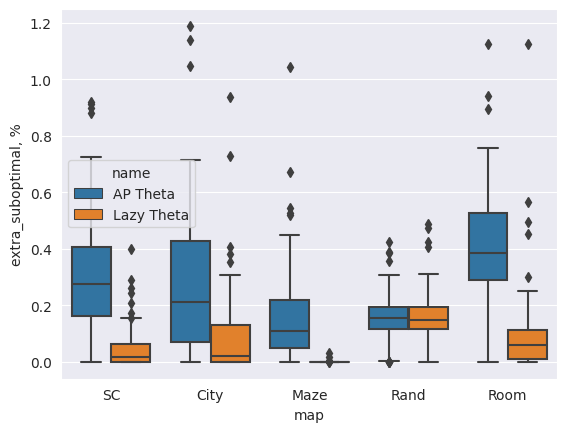

In [42]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.boxplot(data=general_ap_vs_lazy_classic, x="map", y="extra_suboptimal, %", hue="name")

# Weighted heuristic

In [43]:
names_theta_wh = [".lazy_theta.weighted", ".lazy_theta.weighted.w=0.075", ".lazy_theta.weighted.w=0.05",
                  ".lazy_theta.weighted.w=0.025", ".lazy_theta.euclidian"]
labels_theta_wh = ["Lazy Theta 10.0%", "Lazy Theta 7.5%", "Lazy Theta 5.0%",
                   "Lazy Theta 2.5%", "Lazy Theta 0.0%"]

In [44]:
multy_data_theta_wh = load_data(names_theta_wh, labels_theta_wh, "theta/")
count_suboptimal(multy_data_anya, 0, multy_data_theta_wh)
norm_custom_stat(multy_data_theta_wh, 0, multy_data_theta_wh, "runtime")
data_theta_wh = unite_multy_data(multy_data_theta_wh)
general_theta_wh = unite_maps(data_theta_wh)

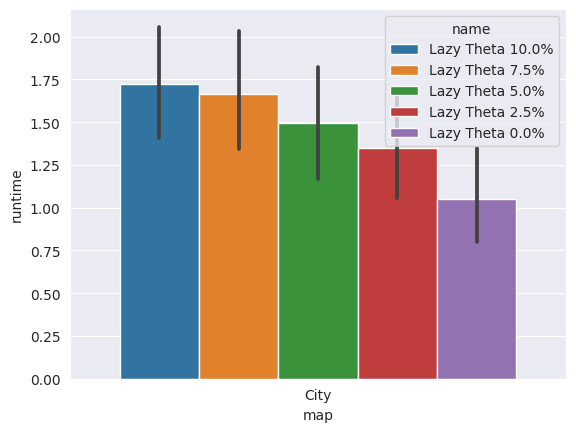

In [45]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=data_theta_wh[1], x="map", y="runtime", hue="name")

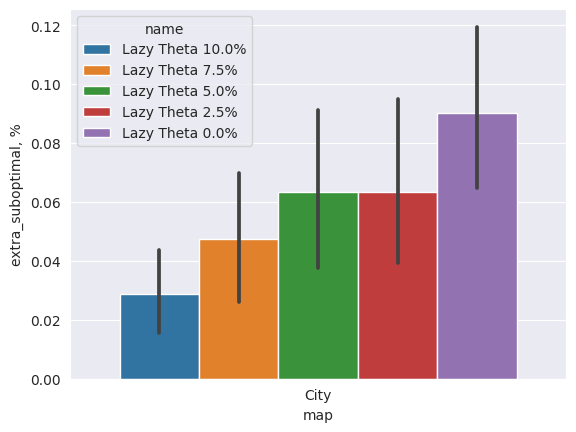

In [46]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=data_theta_wh[1], x="map", y="extra_suboptimal, %", hue="name")

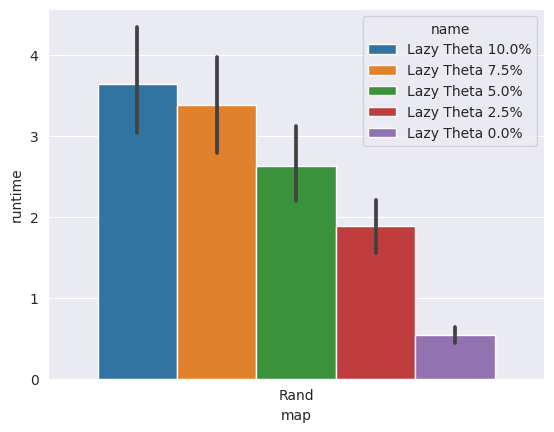

In [47]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=data_theta_wh[3], x="map", y="runtime", hue="name")

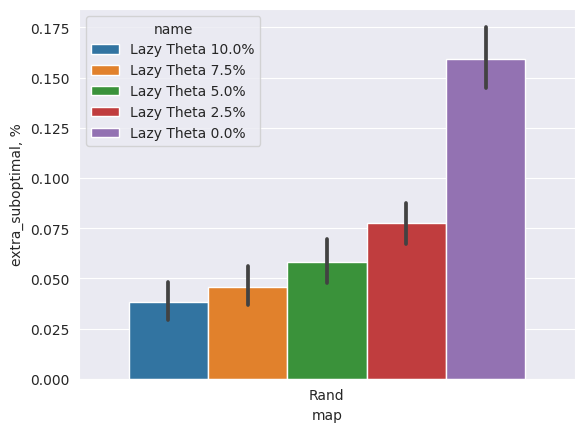

In [48]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=data_theta_wh[3], x="map", y="extra_suboptimal, %", hue="name")

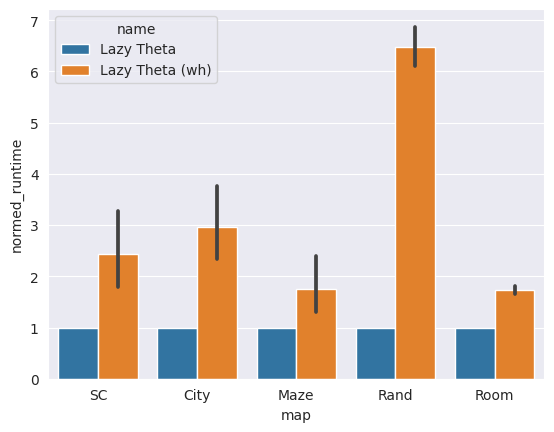

In [49]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=general_wh, x="map", y="normed_runtime", hue="name")

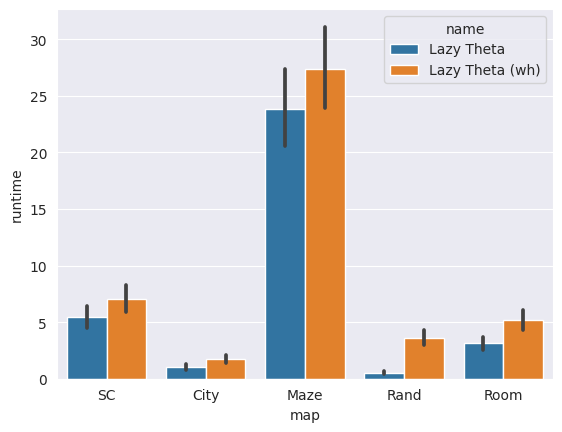

In [50]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=general_wh, x="map", y="runtime", hue="name")

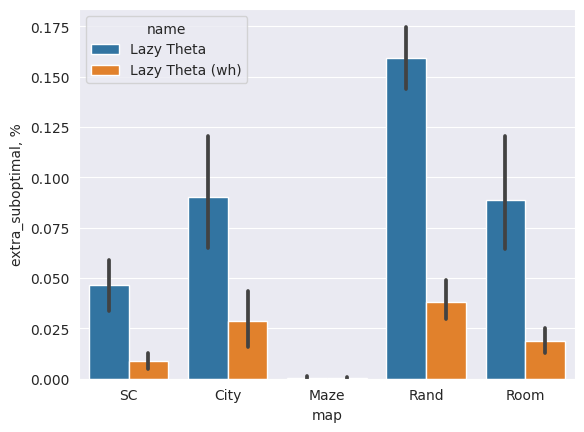

In [51]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=general_wh, x="map", y="extra_suboptimal, %", hue="name")

# 2^k A*

In [52]:
# multy_data_2kastar
# data_2kastar

In [53]:
multy_data_astar_vs_canonical = select_multy_data(multy_data_2kastar, [0, 1, 2, 3, 4, 5])
norm_custom_stat(multy_data_astar_vs_canonical, 0, multy_data_astar_vs_canonical, "runtime")
data_astar_vs_canonical = unite_multy_data(multy_data_astar_vs_canonical)
general_astar_vs_canonical = unite_maps(data_astar_vs_canonical)

# A* vs canonical A*

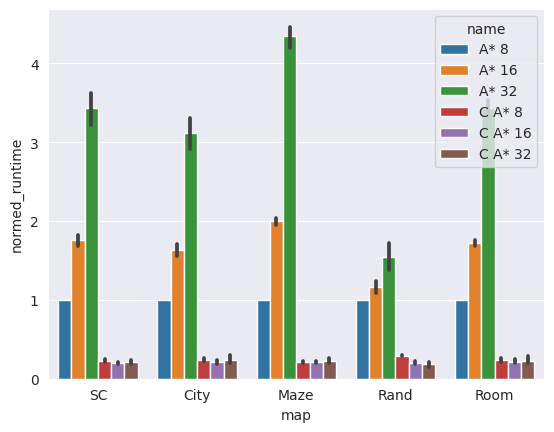

In [54]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=general_astar_vs_canonical, x="map", y="normed_runtime", hue="name")

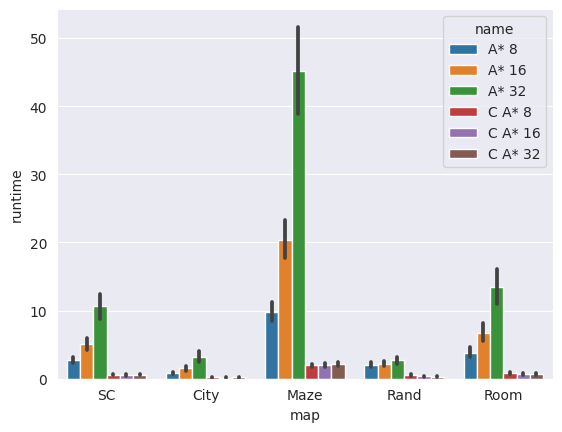

In [55]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=general_astar_vs_canonical, x="map", y="runtime", hue="name")

# k-dynamic

In [56]:
names_2kastar_dyn = [".canonical.euclidian.w=1_k=3", ".canonical.euclidian.w=1_k=4", ".canonical.euclidian.w=1_k=5",
                     ".canonical.euclidian.w=1_k=6", ".canonical.euclidian.w=1_k=7",
                     ".canonical.h_2k.w=1_k=3", ".canonical.h_2k.w=1_k=4", ".canonical.h_2k.w=1_k=5",
                     ".canonical.h_2k.w=1_k=6", ".canonical.h_2k.w=1_k=7"]
labels_2kastar_dyn = ["C A* 8 eu", "C A* 16 eu", "C A* 32 eu",
                      "C A* 64 eu", "C A* 128 eu",
                      "C A* 8 h_2k", "C A* 16 h_2k", "C A* 32 h_2k",
                      "C A* 64 h_2k", "C A* 128 h_2k"]
ks_2kastar = ["3", "4", "5", "6", "7", "3", "4", "5", "6", "7"] 
heu_2kastar = ["eu", "eu", "eu", "eu", "eu", "h_2k", "h_2k", "h_2k", "h_2k", "h_2k"] 

In [57]:
multy_data_2kastar_dynamic = load_data_hk(names_2kastar_dyn, labels_2kastar_dyn, heu_2kastar, ks_2kastar, "astar_2k/")
count_suboptimal(multy_data_anya, 0, multy_data_2kastar_dynamic)
norm_custom_stat(multy_data_2kastar_dynamic, 0, multy_data_2kastar_dynamic, "runtime")
data_2kastar_dynamic = unite_multy_data(multy_data_2kastar_dynamic)
general_2kastar_dynamic = unite_maps(data_2kastar_dynamic)

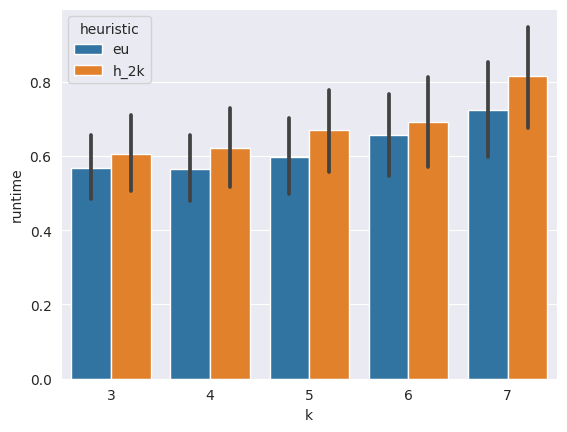

In [58]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=data_2kastar_dynamic[0], x="k", y="runtime", hue="heuristic")

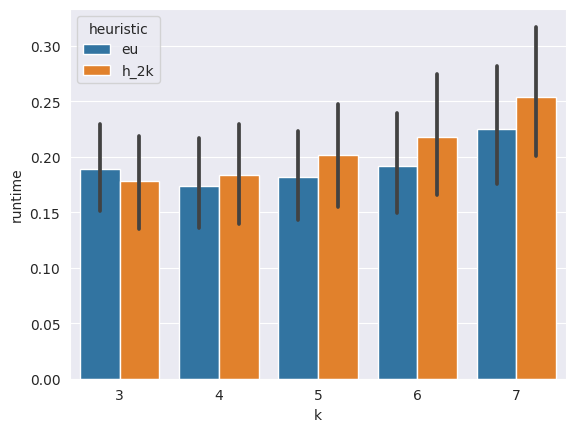

In [59]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=data_2kastar_dynamic[1], x="k", y="runtime", hue="heuristic")

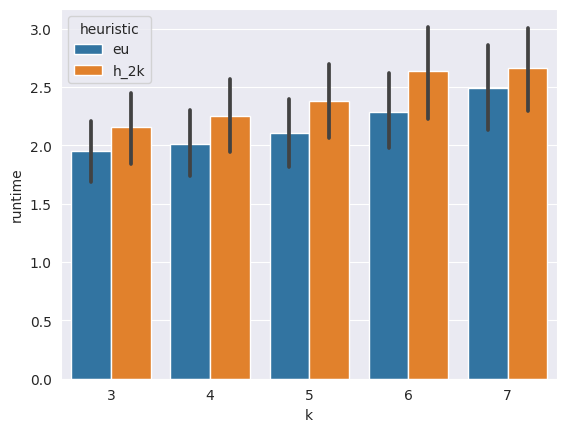

In [60]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=data_2kastar_dynamic[2], x="k", y="runtime", hue="heuristic")

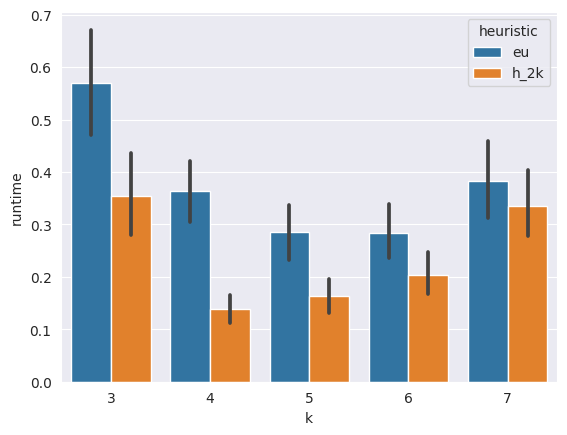

In [61]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=data_2kastar_dynamic[3], x="k", y="runtime", hue="heuristic")

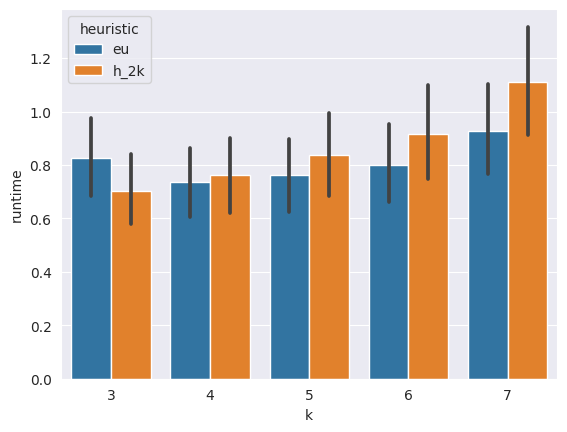

In [62]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=data_2kastar_dynamic[4], x="k", y="runtime", hue="heuristic")

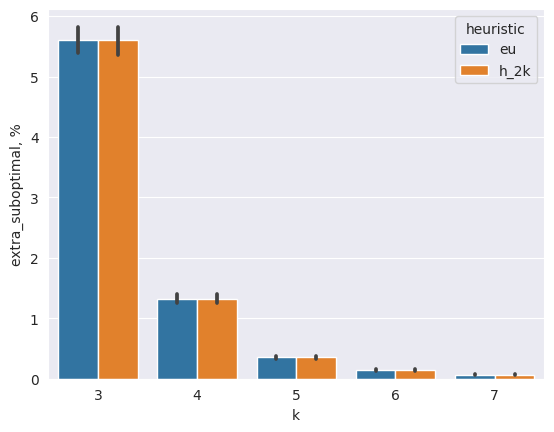

In [63]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=data_2kastar_dynamic[0], x="k", y="extra_suboptimal, %", hue="heuristic")

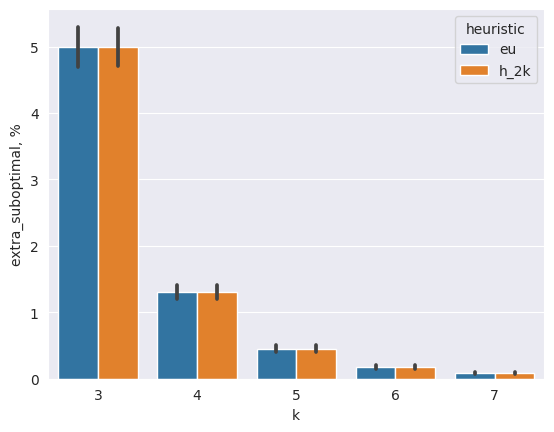

In [64]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=data_2kastar_dynamic[1], x="k", y="extra_suboptimal, %", hue="heuristic")

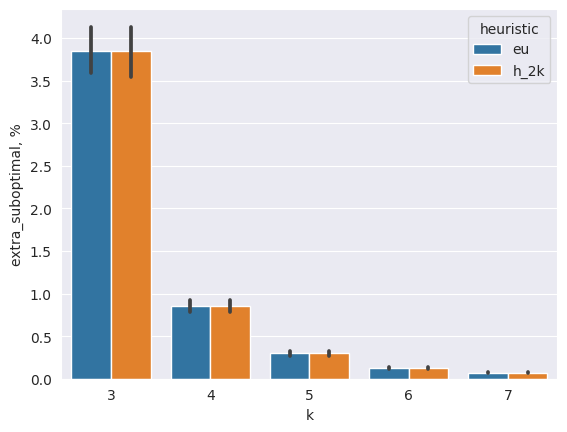

In [65]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=data_2kastar_dynamic[2], x="k", y="extra_suboptimal, %", hue="heuristic")

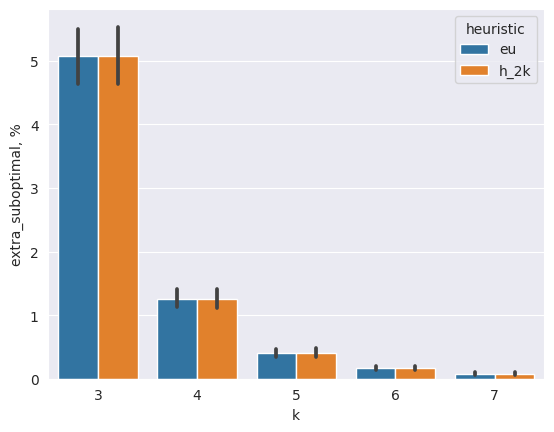

In [66]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=data_2kastar_dynamic[3], x="k", y="extra_suboptimal, %", hue="heuristic")

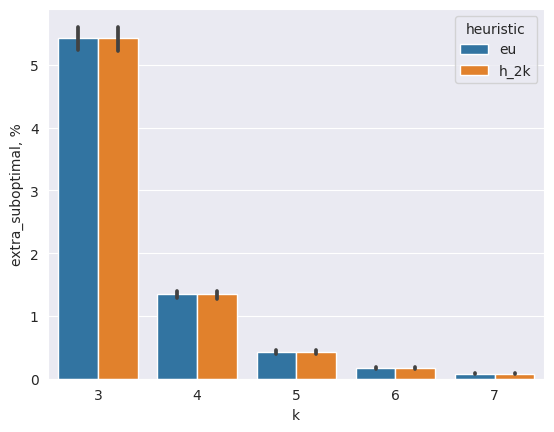

In [67]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=data_2kastar_dynamic[4], x="k", y="extra_suboptimal, %", hue="heuristic")

# Time / Suboptimal view

In [68]:
runtime_data_2kastar_dyn = smooth_data_hk("runtime", data_2kastar_dynamic, labels_2kastar_dyn, heu_2kastar, ks_2kastar)
suboptimal_data_2kastar_dyn = smooth_data_hk("extra_suboptimal, %", data_2kastar_dynamic, labels_2kastar_dyn, heu_2kastar, ks_2kastar)

In [69]:
smoothed_data_2kastar_dyn = [runtime_data_2kastar_dyn[i].merge(suboptimal_data_2kastar_dyn[i]) for i in range(len(folders))]

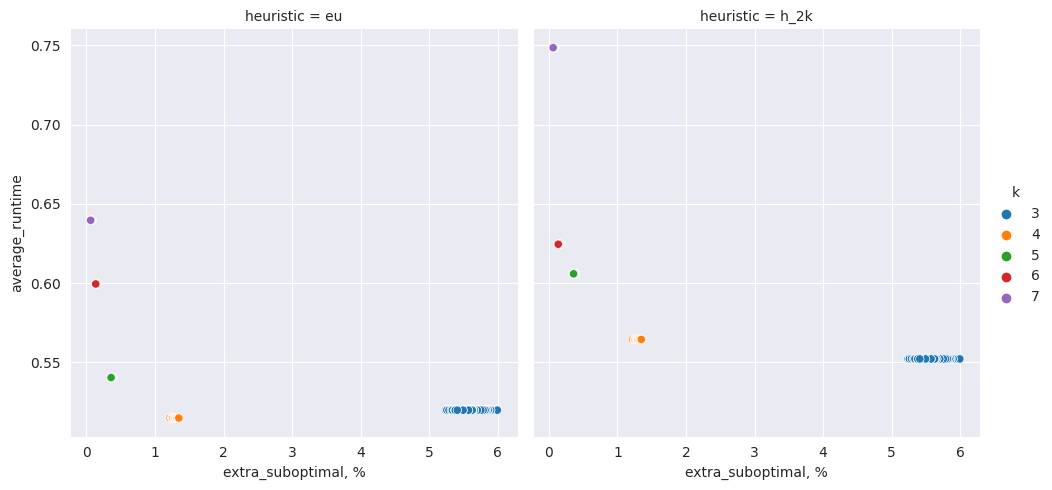

In [70]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    g = sns.relplot(data=smoothed_data_2kastar_dyn[0], x="extra_suboptimal, %", y="average_runtime", hue = "k", col="heuristic")
#     for ax in g.axes[0]:
#         ax.invert_xaxis()

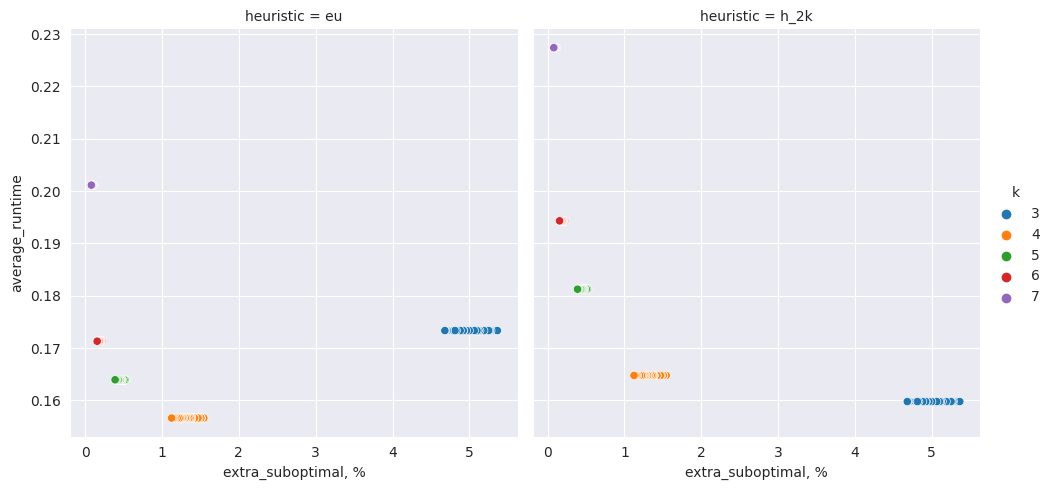

In [71]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    g = sns.relplot(data=smoothed_data_2kastar_dyn[1], x="extra_suboptimal, %", y="average_runtime", hue = "k", col="heuristic")
#     for ax in g.axes[0]:
#         ax.invert_xaxis()

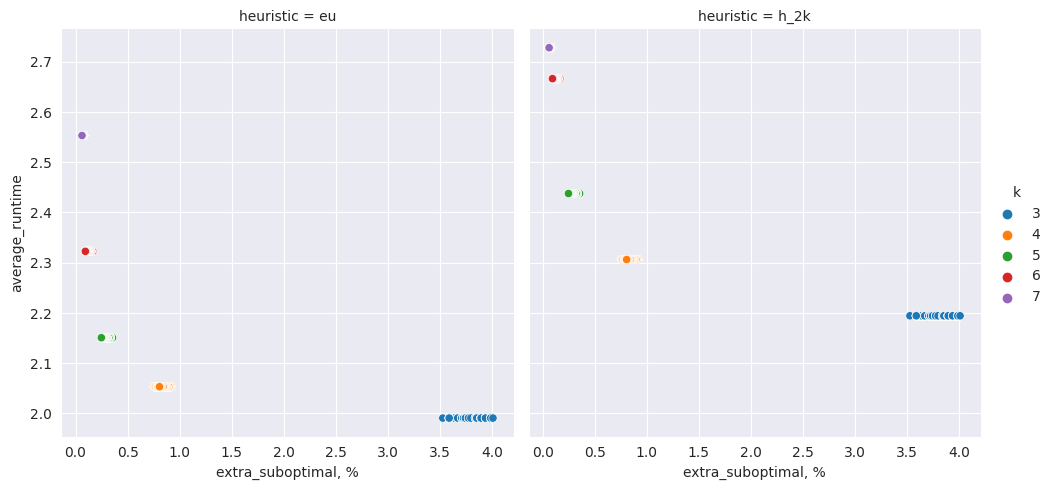

In [72]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    g = sns.relplot(data=smoothed_data_2kastar_dyn[2], x="extra_suboptimal, %", y="average_runtime", hue = "k", col="heuristic")
#     for ax in g.axes[0]:
#         ax.invert_xaxis()

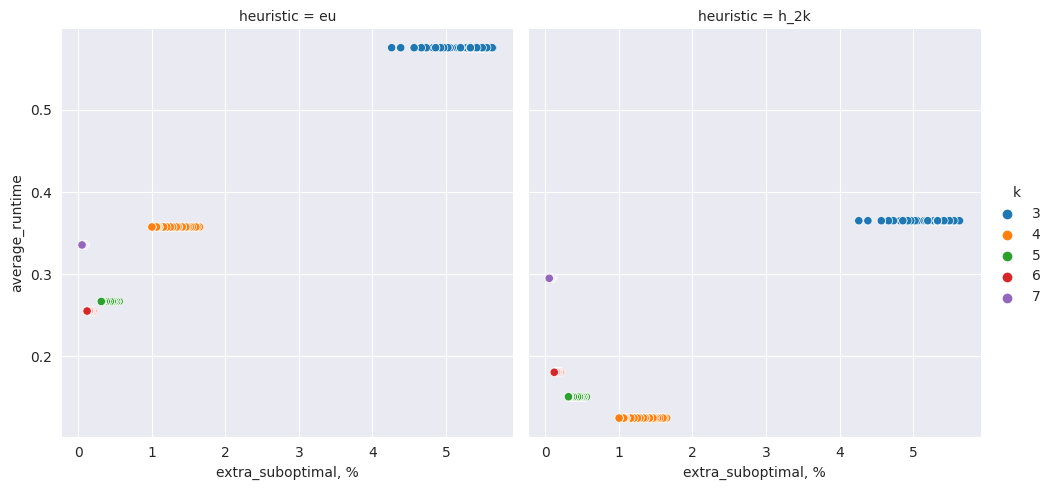

In [73]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    g = sns.relplot(data=smoothed_data_2kastar_dyn[3], x="extra_suboptimal, %", y="average_runtime", hue = "k", col="heuristic")
#     for ax in g.axes[0]:
#         ax.invert_xaxis()

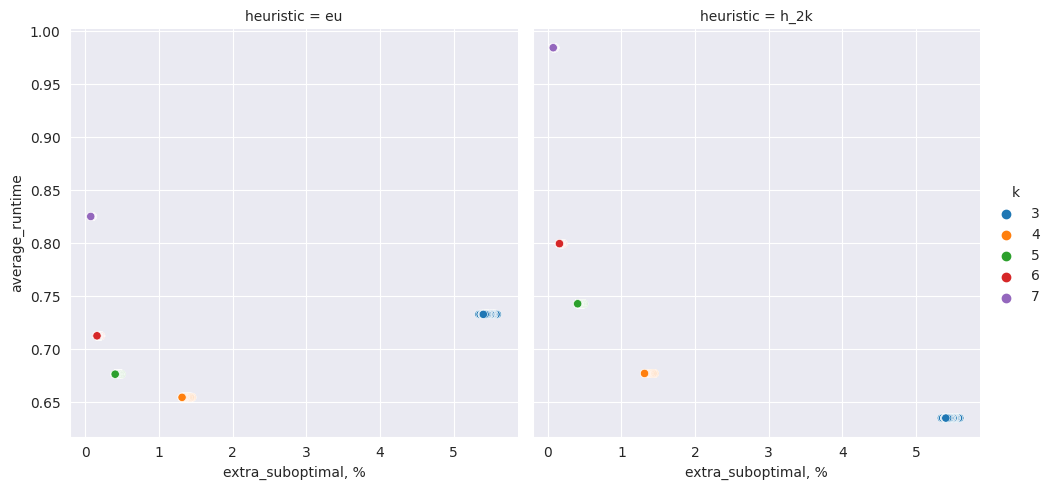

In [74]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    g = sns.relplot(data=smoothed_data_2kastar_dyn[4], x="extra_suboptimal, %", y="average_runtime", hue = "k", col="heuristic")
#     for ax in g.axes[0]:
#         ax.invert_xaxis()

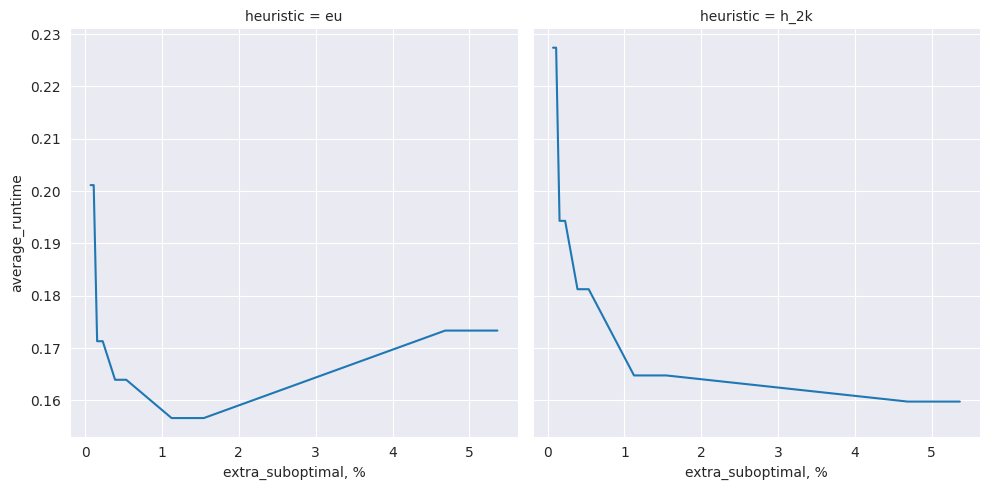

In [75]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.relplot(data=smoothed_data_2kastar_dyn[1], x="extra_suboptimal, %", y="average_runtime", kind="line", col="heuristic")

# All

In [76]:
main_data = []
main_labels = ["AP Theta", "Lazy Theta", "Anya", "C A* 128"]
for i in range(len(folders)):
    main_table = pd.DataFrame()
    main_table = pd.concat([main_table, data_anya[i]], ignore_index = True)
    main_table = pd.concat([main_table, data_final_theta[i]], ignore_index = True)
    main_table = pd.concat([main_table, data_final_2kastar[i]], ignore_index = True)
    main_data.append(main_table)

In [77]:
main_data_2 = []
for i in range(len(folders)):
    main_table = pd.DataFrame()
    main_table = pd.concat([main_table, data_final2_2kastar[i]], ignore_index = True)
    main_table = pd.concat([main_table, data_anya[i]], ignore_index = True)
    main_table = pd.concat([main_table, data_final_theta[i]], ignore_index = True)
    main_data_2.append(main_table)

In [78]:
general_anya = unite_maps(data_anya)

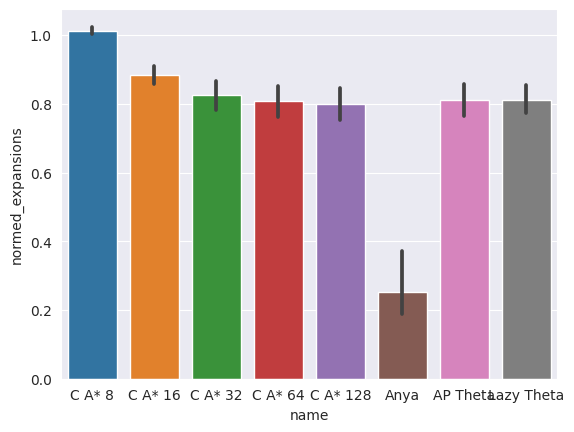

In [79]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=main_data_2[0], x="name", y="normed_expansions")

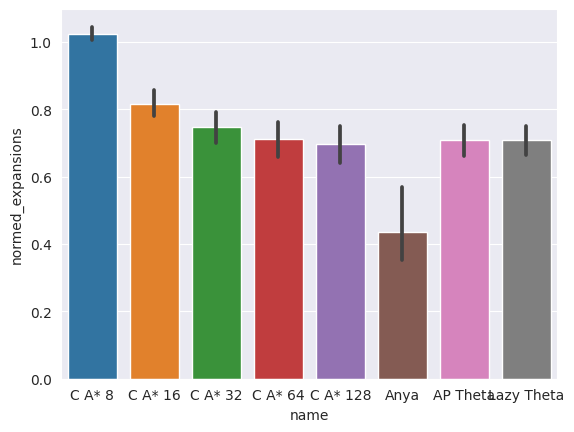

In [80]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=main_data_2[1], x="name", y="normed_expansions")

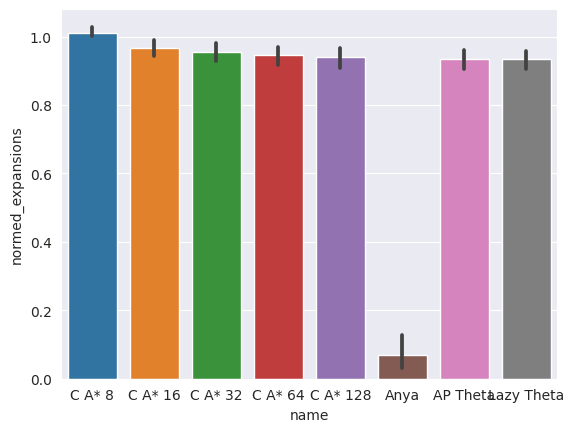

In [81]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=main_data_2[2], x="name", y="normed_expansions")

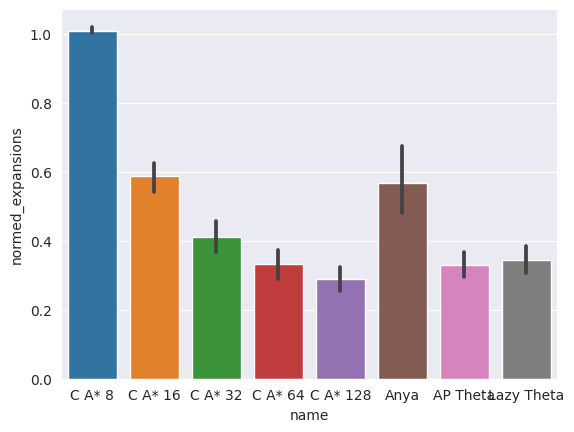

In [82]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=main_data_2[3], x="name", y="normed_expansions")

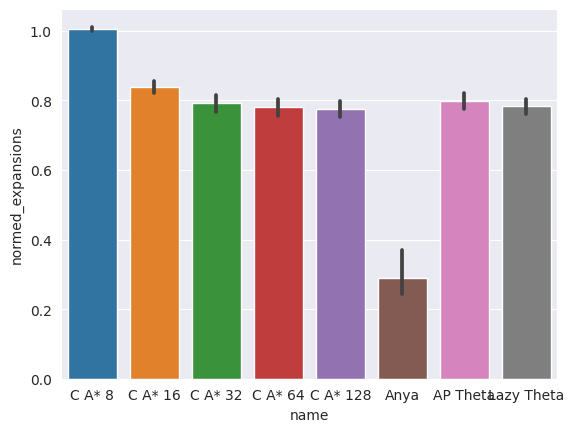

In [83]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=main_data_2[4], x="name", y="normed_expansions")

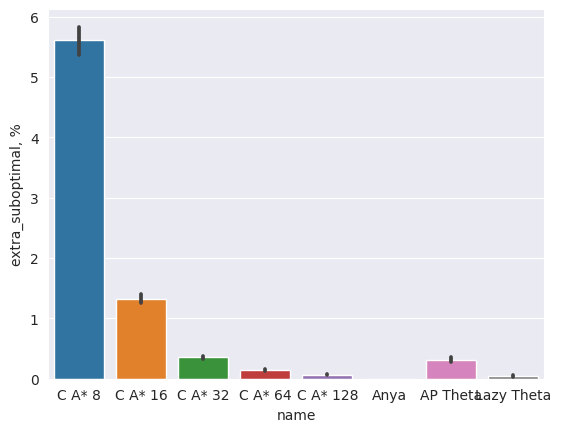

In [84]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=main_data_2[0], x="name", y="extra_suboptimal, %")

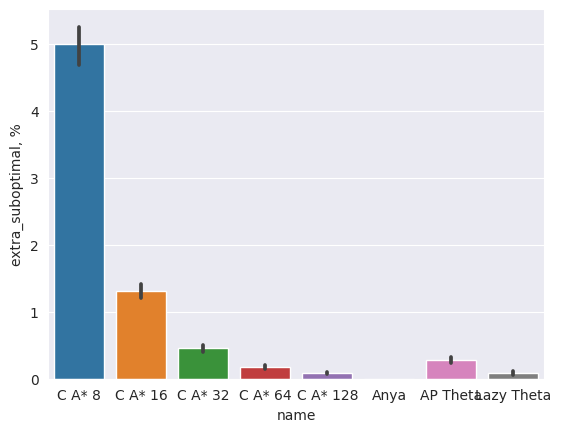

In [85]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=main_data_2[1], x="name", y="extra_suboptimal, %")

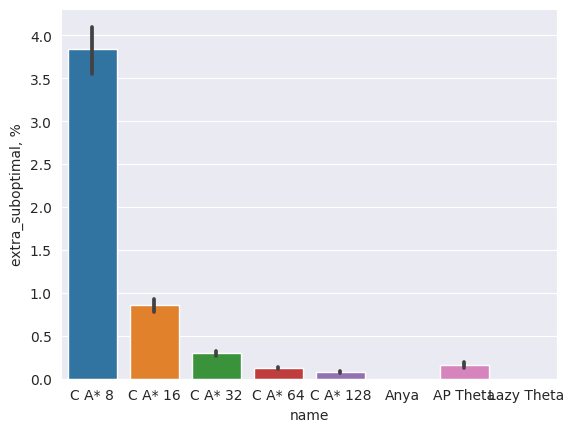

In [86]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=main_data_2[2], x="name", y="extra_suboptimal, %")

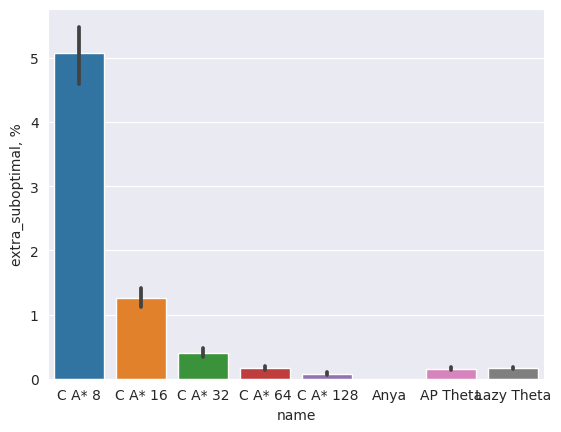

In [87]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=main_data_2[3], x="name", y="extra_suboptimal, %")

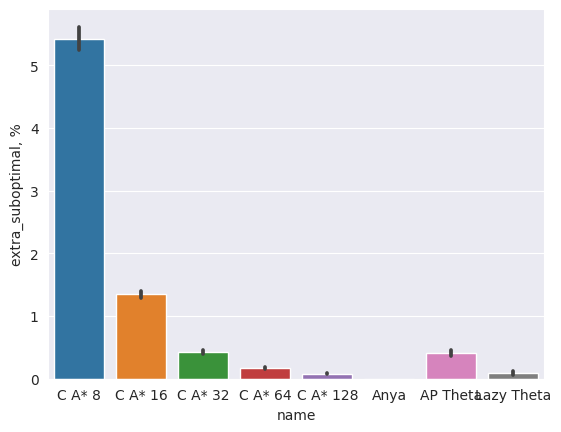

In [88]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=main_data_2[4], x="name", y="extra_suboptimal, %")

In [89]:
runtime_main_data = smooth_data("runtime", main_data, main_labels)

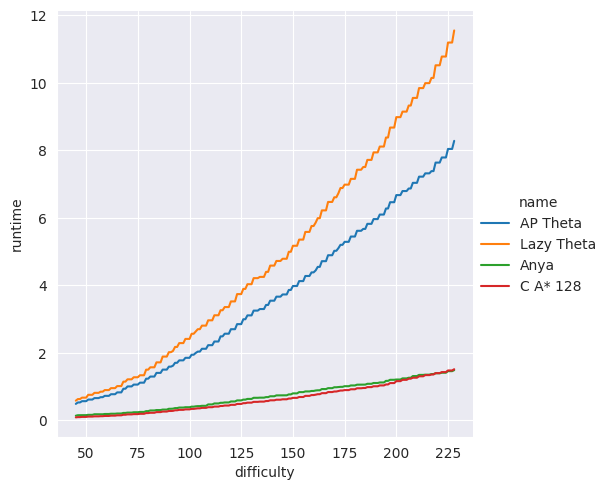

In [90]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.relplot(data=runtime_main_data[0], x="difficulty", y="runtime", hue = "name", kind="line")

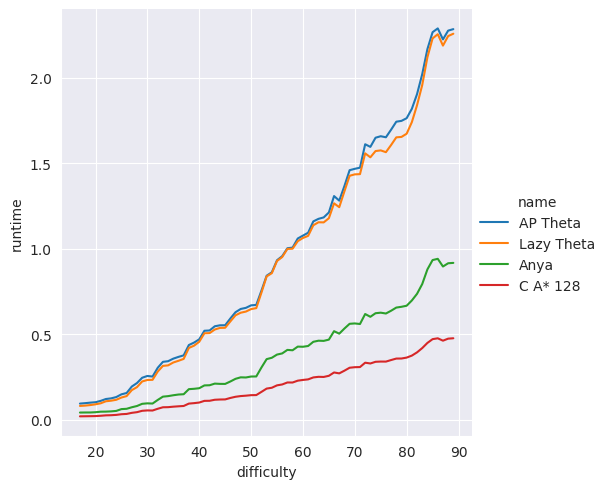

In [91]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.relplot(data=runtime_main_data[1], x="difficulty", y="runtime", hue = "name", kind="line")

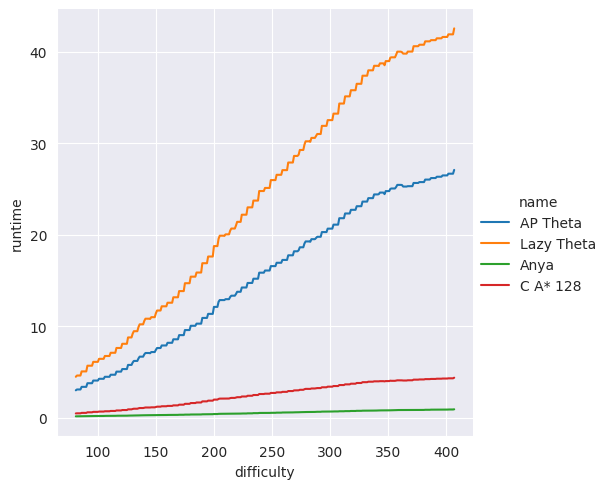

In [92]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.relplot(data=runtime_main_data[2], x="difficulty", y="runtime", hue = "name", kind="line")

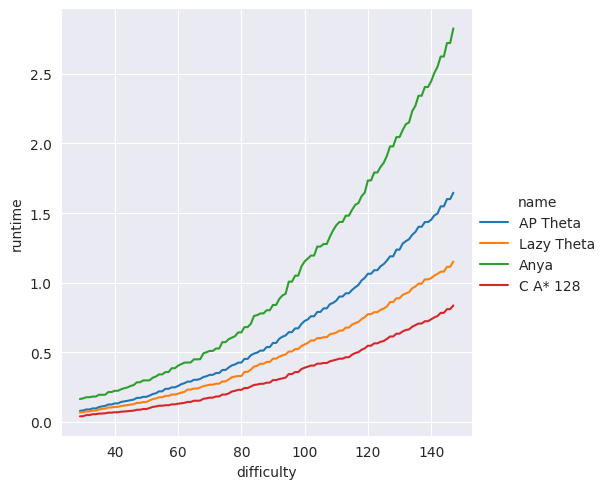

In [93]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.relplot(data=runtime_main_data[3], x="difficulty", y="runtime", hue = "name", kind="line")

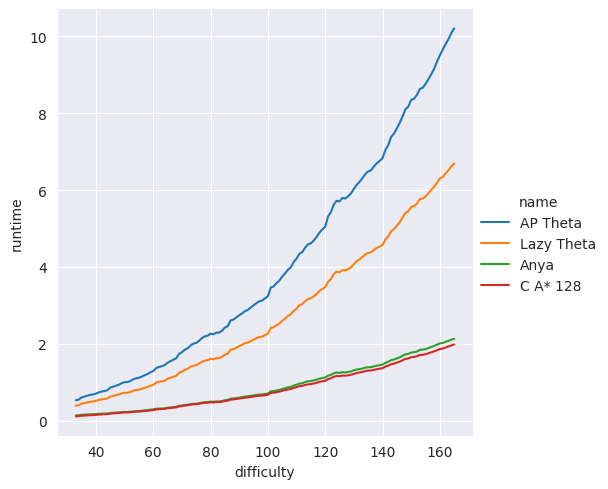

In [94]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.relplot(data=runtime_main_data[4], x="difficulty", y="runtime", hue = "name", kind="line")

# Other

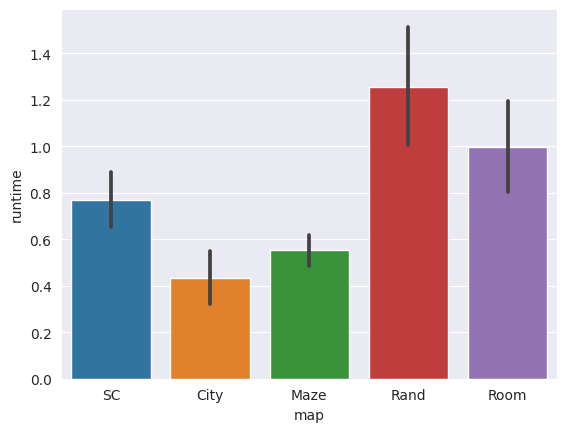

In [95]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.barplot(data=general_anya, x="map", y="runtime")

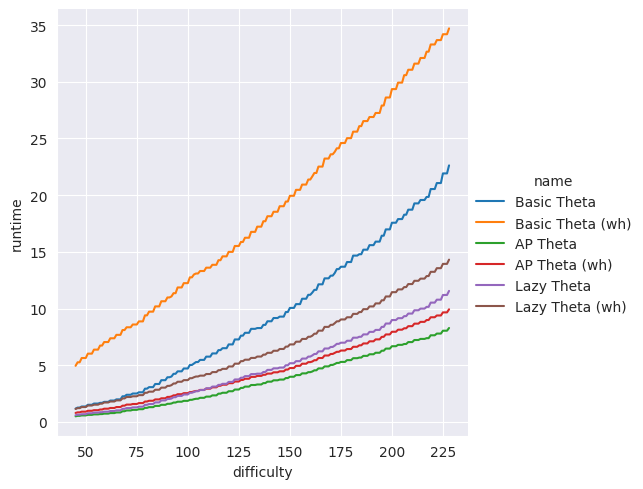

In [96]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.relplot(data=runtime_data_theta[0], x="difficulty", y="runtime", hue = "name", kind="line")

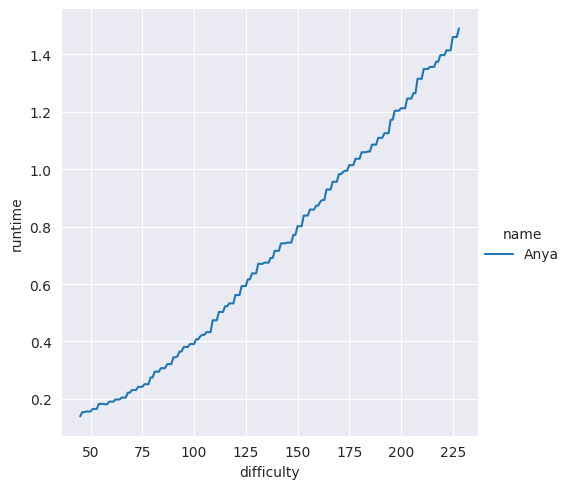

In [97]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.relplot(data=runtime_data_anya[0], x="difficulty", y="runtime", hue = "name", kind="line")